### This Entire notebook represents the ml performance on differnet predictive models with the comapriosn of three common most data imbalance techniques(Random Oversampler, Random Undersampler and SMOTE) with interpretability on SHAP(which features has play a vital role in the preformance of the model). Finally the export of pred_proba(predication probability of fires in each spatial location) from best perfromer model with best imabalance method


In [ ]:
# This are the packages i have used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Imbalance methods
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



from google.colab import drive
from google.colab import files
import shutil

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/final/dataset_with_firelabel.csv")

In [ ]:
df.columns

In [ ]:
df.drop(['eastness', 'slope_cat','dist_to_powerplant_m'], axis=1, inplace=True)

In [ ]:
# .T represents the columns in vertical form

df.describe(include='all').T

In [ ]:
# Just to final check the missing counts in entire dataset

na=df.isna().sum().sort_values(ascending=False)
na_pct=(df.isna().mean()*100).sort_values(ascending=False)
df=pd.DataFrame({"missing_count": na, "missing_percent": na_pct})

df.head()

In [ ]:
# Reload the original dataframe
df=pd.read_csv("/content/drive/MyDrive/final/dataset_with_firelabel.csv")

# Replace NaNs with 0 in the 'ndvi_interp' column
df['ndvi_interp'].fillna(0, inplace=True)

In [ ]:
# Just to show the postivie rate of my target(fire)



df = pd.read_csv("/content/final.csv")  # <— adjust path if needed
TARGET = "fire_label"

# Numeric predictors (drop target + coords if present)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols: num_cols.remove(TARGET)
for c in ['fire_label','dist_to_powerplant_m','slope_cat','eastness','month']:
    if c in num_cols: num_cols.remove(c)

X = df[num_cols].copy()
y = df[TARGET].astype(int).copy()

print(f"X shape: {X.shape}, y positive rate: {y.mean():.6f}")

In [ ]:
# Train/Test split: 80:20. Trainned and still has lot of imabalance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(y_train.value_counts(normalize=True).rename("train class ratio"))
print(y_test.value_counts(normalize=True).rename("test class ratio"))

In [ ]:
# ~1:5 minority:majority ratio (liao et al., 2025) - This one is reference
RATIO= 0.2
imb_methods = {
    "None":  None,
    "RUS":   RandomUnderSampler(sampling_strategy=RATIO, random_state=42),
    "ROS":   RandomOverSampler(sampling_strategy=RATIO, random_state=42),
    "SMOTE": SMOTE(sampling_strategy=RATIO, random_state=42),
}

In [ ]:
# Hyperparameter tunned as per section 3.7.5 - This is dissertation section

models = {}

# Logistic Regression with scaling
models["LR"] = LogisticRegression(solver="lbfgs",
    max_iter=100,random_state=42)

# Decision Tree
models["DT"] = DecisionTreeClassifier(max_depth=5,min_samples_split=2,
   random_state=42)

# Random Forest
models["RF"] = RandomForestClassifier(n_estimators=550,
max_depth=10,random_state=42,criterion="gini",
    min_samples_split=2,
    min_samples_leaf=1
)

# XGBoost or fallback to GradientBoosting
if HAS_XGB:
    models["XGB"] = XGBClassifier(    n_estimators=300,
        learning_rate=0.05,min_child_weight=12,n_bins=107,random_state=42
    )
else:
    models["XGB(fallback=GB)"] = GradientBoostingClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42
    )

In [ ]:

# tested on unseen data as per section 3.7.6.
def evaluate(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)
    # For AUC, use proba if available; otherwise decision_function; otherwise yhat
    try:
        yprob = model.predict_proba(Xte)[:, 1]
    except Exception:
        try:
            yprob = model.decision_function(Xte)
        except Exception:
            yprob = yhat.astype(float)

    return {
        "Accuracy":  accuracy_score(yte, yhat),
        "Precision": precision_score(yte, yhat, zero_division=0),
        "Recall":    recall_score(yte, yhat, zero_division=0),
        "F1":        f1_score(yte, yhat, zero_division=0),
        "AUC":       roc_auc_score(yte, yprob)
    }

records = []

for imb_name, imb in imb_methods.items():
    for mname, base_model in models.items():
        if imb is None:
            # No resampling: fit model directly
            metrics = evaluate(base_model, X_train, y_train, X_test, y_test)
        else:
            # Resample *only* the training set using imblearn pipeline
            imb_pipe = ImbPipeline(steps=[
                ("resample", imb),
                ("model", base_model)
            ])
            metrics = evaluate(imb_pipe, X_train, y_train, X_test, y_test)

        row = {"Imbalance": imb_name, "Model": mname}
        row.update(metrics)
        records.append(row)

results_df = pd.DataFrame(records).sort_values(by=["Imbalance", "Model"]).reset_index(drop=True)
results_df

In [ ]:
# Our resutls shows that RF+ROS has the best F1 and accurate AUC by 1.00 followed by XGBoost with ROS


results_path = "/content/RQ3_imbalance_results.csv"
results_df.to_csv(results_path, index=False)
print("Saved:", results_path)

In [ ]:

# --- Function to create and save bar plots ---
def plot_metric(data, value_col, title, ylabel, filename):
    pivot_table = data.pivot_table(index="Model", columns="Imbalance", values=value_col)
    ax = pivot_table.plot(kind="bar", figsize=(8, 5))

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Model", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)

    # Move legend to the right side
    ax.legend(title="Imbalance", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.show()


# --- Plot AUC ---
plot_metric(
    data=results_df,
    value_col="AUC",
    title="AUC by Model and Imbalance Method",
    ylabel="AUC",
    filename="/content/RQ3_auc_by_method.png"
)

# --- Plot F1 ---
plot_metric(
    data=results_df,
    value_col="F1",
    title="F1-Score by Model and Imbalance Method",
    ylabel="F1-Score",
    filename="/content/RQ3_f1_by_method.png"
)

In [ ]:
# Comparioson Pivot table: Model × Imbalance (F1 values)
f1_pivot = (
    results_df
    .pivot(index='Model', columns='Imbalance', values='F1')
    .sort_index()
)

# Plot heatmap with light-to-dark blue color palette
fig, ax = plt.subplots(figsize=(7, 4.5))
im = ax.imshow(f1_pivot.values, aspect='auto', cmap='Blues')

# Ticks and labels
ax.set_yticks(range(f1_pivot.shape[0]))
ax.set_yticklabels(f1_pivot.index)
ax.set_xticks(range(f1_pivot.shape[1]))
ax.set_xticklabels(f1_pivot.columns, rotation=0)

# Annotate each cell with F1 score
for i in range(f1_pivot.shape[0]):
    for j in range(f1_pivot.shape[1]):
        val = f1_pivot.values[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", va='center', ha='center', color='black')

# Labels and title
ax.set_xlabel("Imbalance Technique")
ax.set_ylabel("Model")
ax.set_title("Model × Imbalance Performance (F1)")

# Add colorbar
cbar = fig.colorbar(im, ax=ax, label="F1")
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# add a rank within each Model: higher F1 is better; if tie, higher AUC wins
df_ranked = (results_df
             .sort_values(['Model', 'F1', 'AUC'], ascending=[True, False, False])
             .groupby('Model', as_index=False)
             .first())

# clean view
best_per_model = df_ranked[['Model','Imbalance','F1','AUC']].rename(
    columns={'Imbalance':'Best_Imbalance'}
)

print("Best imbalance method per model (by F1, tie-break AUC):")
print(best_per_model.to_string(index=False))

# save for reporting
best_per_model.to_csv("best_per_model.csv", index=False)

In [ ]:
# 9) 5-class susceptibility via quantiles
bins = np.quantile(proba_all, [0, .2, .4, .6, .8, 1.0]) ### This ratio is common in every Susceptibility models
labels = ["Very Low","Low","Moderate","High","Very High"]

if len(np.unique(bins)) < len(bins):
    print("[WARN] Duplicate quantile edges detected; switching to equal-width bins.")
    bins = np.linspace(proba_all.min(), proba_all.max(), 6)

suscept = pd.cut(proba_all, bins=bins, labels=labels, include_lowest=True)

# 10) Assemble export (keep coords + target + predictions + ALL predictors used)
out = df.copy()
out["pred_proba"] = proba_all
out["suscept_class"] = suscept

front = [c for c in [LAT_COL, LON_COL, TARGET, "pred_proba", "suscept_class"] if c in out.columns]
# ensure all model features are included in the export too
feature_cols = [c for c in X.columns if c not in front]
other_cols = [c for c in out.columns if c not in front + feature_cols]

final_df = out[front + feature_cols + other_cols]

# 11) Save
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
final_df.to_csv(OUT_CSV, index=False)
print(f"\n✅ Exported: {OUT_CSV}")
print(f"Rows: {len(final_df):,} | Columns: {len(final_df.columns)}")
print(final_df.head())

### This is the output when you combined every block of codes into a single cell and runs sequently

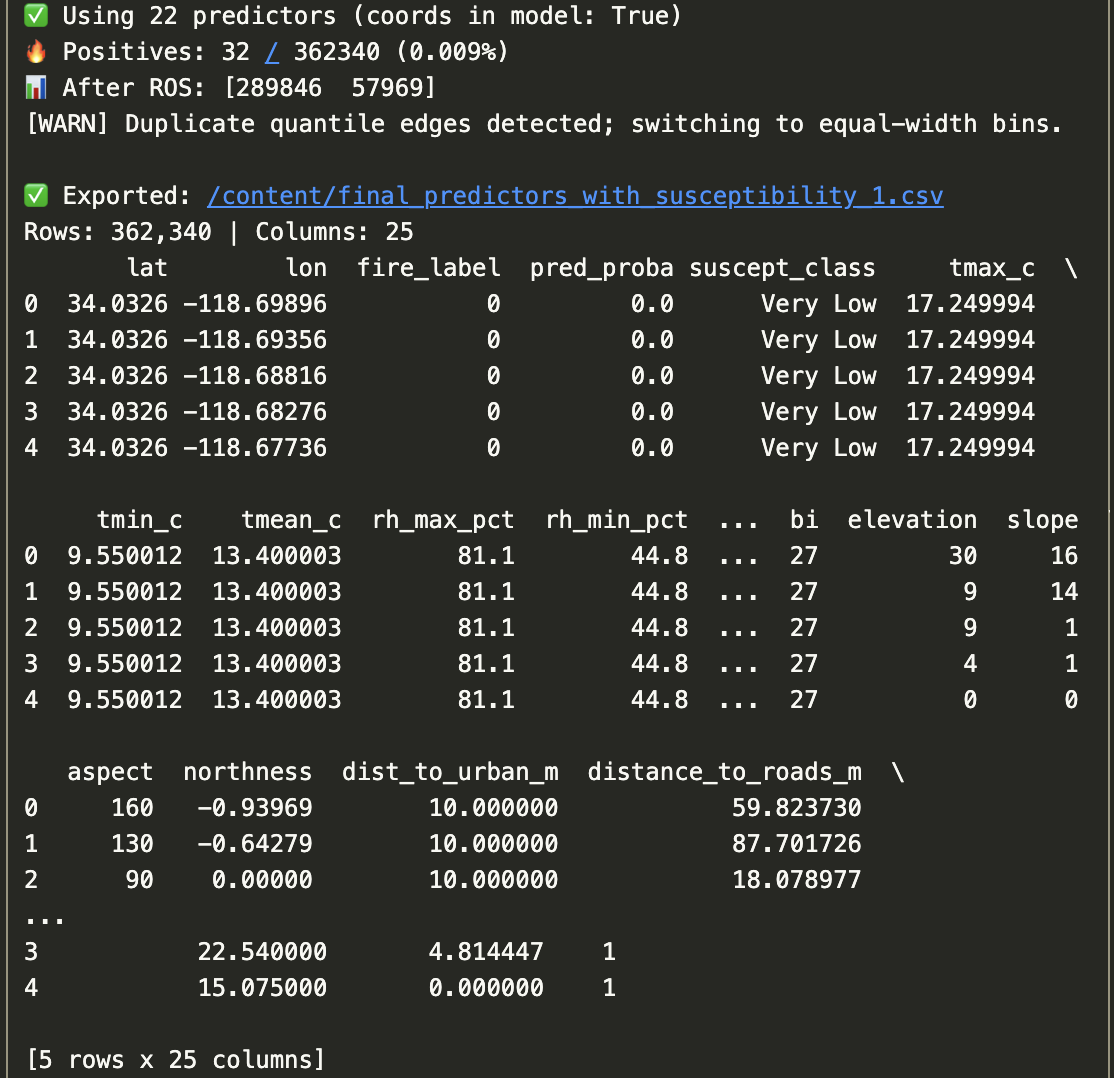

### This is just to see the value counts in each and ever susceptibility 

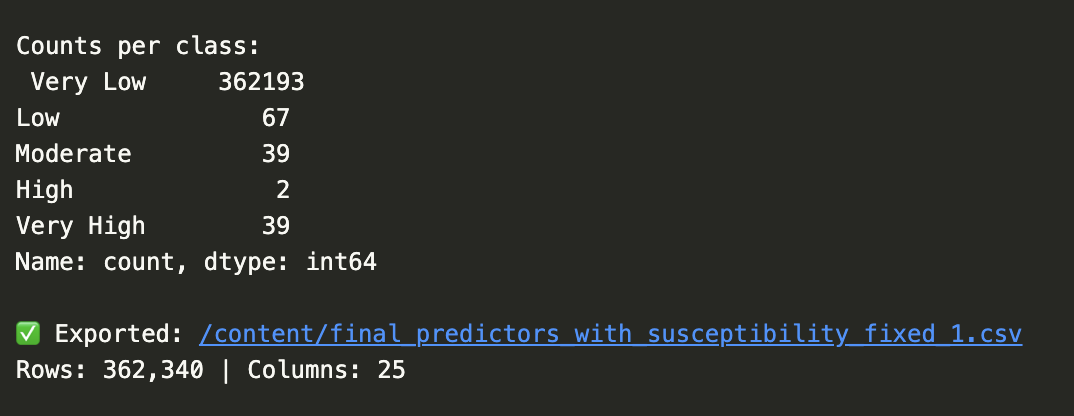

### By importing this csv into softwares like QGIS or ArcGis to convert the values from numeric into five major susceptibility colours